# Benchmark: GeoParquet Encoding (WKB vs GeoArrow)

*AI-generated notebook, manually reviewed*

This notebook benchmarks read/write operations for `geopandas.GeoDataFrame` to Parquet format, comparing:
1. Two geometry encodings: **WKB** and **geoarrow**
2. Two approaches: **plain geopandas** vs **spatialdata**

Each write operation is run 3 times to compute mean and standard deviation.

In [1]:
import tempfile
import time
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

import spatialdata as sd
from spatialdata.models import ShapesModel

/opt/miniconda3/envs/ome/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configuration

In [2]:
# Data sizes to benchmark
SIZES = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000, 10_000_000]

# Number of repetitions for each benchmark
N_REPS = 3

# Geometry encodings to compare
ENCODINGS = ["WKB", "geoarrow"]

# Methods to compare
METHODS = ["geopandas", "spatialdata"]

## Helper Functions

In [3]:
def generate_random_polygons(n: int, seed: int = 42) -> gpd.GeoDataFrame:
    """Generate a GeoDataFrame with n random polygons."""
    rng = np.random.default_rng(seed)
    
    # Generate random polygon centers
    centers_x = rng.uniform(0, 10000, n)
    centers_y = rng.uniform(0, 10000, n)
    
    # Generate random polygon sizes
    sizes = rng.uniform(10, 100, n)
    
    # Create polygons (simple squares for benchmarking)
    polygons = []
    for cx, cy, s in zip(centers_x, centers_y, sizes):
        # Create a simple square polygon
        polygon = Polygon([
            (cx - s/2, cy - s/2),
            (cx + s/2, cy - s/2),
            (cx + s/2, cy + s/2),
            (cx - s/2, cy + s/2),
            (cx - s/2, cy - s/2)  # close the polygon
        ])
        polygons.append(polygon)
    
    # Create GeoDataFrame with additional columns
    gdf = gpd.GeoDataFrame({
        'geometry': polygons,
        'area': [p.area for p in polygons],
        'category': rng.choice(['A', 'B', 'C', 'D'], n),
        'value': rng.uniform(0, 1, n)
    })
    
    return gdf


def generate_random_circles(n: int, seed: int = 42) -> gpd.GeoDataFrame:
    """Generate a GeoDataFrame with n random circles (points with radius)."""
    rng = np.random.default_rng(seed)
    
    # Generate random point centers
    centers_x = rng.uniform(0, 10000, n)
    centers_y = rng.uniform(0, 10000, n)
    
    # Generate random radii
    radii = rng.uniform(5, 50, n)
    
    # Create points
    points = [Point(cx, cy) for cx, cy in zip(centers_x, centers_y)]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'geometry': points,
        'radius': radii,
        'category': rng.choice(['A', 'B', 'C', 'D'], n),
        'value': rng.uniform(0, 1, n)
    })
    
    return gdf

In [4]:
def benchmark_geopandas_write(gdf: gpd.GeoDataFrame, path: Path, encoding: str) -> float:
    """Benchmark geopandas write operation."""
    start = time.perf_counter()
    gdf.to_parquet(path, geometry_encoding=encoding)
    end = time.perf_counter()
    return end - start


def benchmark_geopandas_read(path: Path) -> tuple[gpd.GeoDataFrame, float]:
    """Benchmark geopandas read operation."""
    start = time.perf_counter()
    gdf = gpd.read_parquet(path)
    end = time.perf_counter()
    return gdf, end - start


def benchmark_spatialdata_write(gdf: gpd.GeoDataFrame, path: Path, encoding: str) -> float:
    """Benchmark spatialdata write operation."""
    # Parse the GeoDataFrame to add required transformations
    shapes = ShapesModel.parse(gdf)
    
    start = time.perf_counter()
    sdata = sd.SpatialData.init_from_elements({"shapes": shapes})
    sdata.write(path, shapes_geometry_encoding=encoding)
    end = time.perf_counter()
    return end - start


def benchmark_spatialdata_read(path: Path) -> tuple[sd.SpatialData, float]:
    """Benchmark spatialdata read operation."""
    start = time.perf_counter()
    sdata = sd.read_zarr(path)
    end = time.perf_counter()
    return sdata, end - start

## Run Benchmarks

In [ ]:
def run_benchmarks(geometry_type: str = "polygons"):
    """Run all benchmarks for the given geometry type."""
    results = []
    
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        print(f"Using temp directory: {temp_dir}")
        
        for size in SIZES:
            print(f"\nBenchmarking size: {size:,}")
            
            # Generate data
            if geometry_type == "polygons":
                gdf = generate_random_polygons(size)
            else:
                gdf = generate_random_circles(size)
            
            for encoding in ENCODINGS:
                print(f"  Encoding: {encoding}")
                
                # Benchmark geopandas
                write_times_gpd = []
                read_times_gpd = []
                
                for rep in range(N_REPS):
                    parquet_path = temp_dir / f"test_{size}_{encoding}_{rep}.parquet"
                    
                    # Write
                    write_time = benchmark_geopandas_write(gdf, parquet_path, encoding)
                    write_times_gpd.append(write_time)
                    
                    # Read
                    _, read_time = benchmark_geopandas_read(parquet_path)
                    read_times_gpd.append(read_time)
                    
                    # Cleanup
                    parquet_path.unlink()
                
                results.append({
                    'size': size,
                    'encoding': encoding,
                    'method': 'geopandas',
                    'write_mean': np.mean(write_times_gpd),
                    'write_std': np.std(write_times_gpd),
                    'read_mean': np.mean(read_times_gpd),
                    'read_std': np.std(read_times_gpd),
                })
                
                # Benchmark spatialdata
                write_times_sd = []
                read_times_sd = []
                
                for rep in range(N_REPS):
                    zarr_path = temp_dir / f"test_{size}_{encoding}_{rep}.zarr"
                    
                    # Write
                    write_time = benchmark_spatialdata_write(gdf.copy(), zarr_path, encoding)
                    write_times_sd.append(write_time)
                    
                    # Read
                    _, read_time = benchmark_spatialdata_read(zarr_path)
                    read_times_sd.append(read_time)
                    
                    # Cleanup
                    shutil.rmtree(zarr_path)
                
                results.append({
                    'size': size,
                    'encoding': encoding,
                    'method': 'spatialdata',
                    'write_mean': np.mean(write_times_sd),
                    'write_std': np.std(write_times_sd),
                    'read_mean': np.mean(read_times_sd),
                    'read_std': np.std(read_times_sd),
                })
                
                print(f"    geopandas - write: {np.mean(write_times_gpd):.4f}s, read: {np.mean(read_times_gpd):.4f}s")
                print(f"    spatialdata - write: {np.mean(write_times_sd):.4f}s, read: {np.mean(read_times_sd):.4f}s")
        
        print(f"\nCleaned up temp directory")
    
    return pd.DataFrame(results)

In [6]:
# Run benchmarks for polygons
print("="*60)
print("BENCHMARKING POLYGONS")
print("="*60)
results_polygons = run_benchmarks(geometry_type="polygons")

BENCHMARKING POLYGONS
Using temp directory: /tmp/tmpn52ssqj0

Benchmarking size: 1,000
  Encoding: WKB
    geopandas - write: 0.0019s, read: 0.0015s
    spatialdata - write: 0.0086s, read: 0.0027s
  Encoding: geoarrow
    geopandas - write: 0.0018s, read: 0.0012s
    spatialdata - write: 0.0080s, read: 0.0027s

Benchmarking size: 5,000
  Encoding: WKB
    geopandas - write: 0.0032s, read: 0.0019s
    spatialdata - write: 0.0102s, read: 0.0037s
  Encoding: geoarrow
    geopandas - write: 0.0044s, read: 0.0021s
    spatialdata - write: 0.0112s, read: 0.0038s

Benchmarking size: 10,000
  Encoding: WKB
    geopandas - write: 0.0055s, read: 0.0030s
    spatialdata - write: 0.0127s, read: 0.0045s
  Encoding: geoarrow
    geopandas - write: 0.0076s, read: 0.0030s
    spatialdata - write: 0.0145s, read: 0.0047s

Benchmarking size: 50,000
  Encoding: WKB
    geopandas - write: 0.0238s, read: 0.0119s
    spatialdata - write: 0.0312s, read: 0.0141s
  Encoding: geoarrow
    geopandas - write: 0.03

In [7]:
# Run benchmarks for circles (points with radius)
print("="*60)
print("BENCHMARKING CIRCLES (Points)")
print("="*60)
results_circles = run_benchmarks(geometry_type="circles")

BENCHMARKING CIRCLES (Points)
Using temp directory: /tmp/tmp8klgep91

Benchmarking size: 1,000
  Encoding: WKB
    geopandas - write: 0.0020s, read: 0.0023s
    spatialdata - write: 0.0163s, read: 0.0057s
  Encoding: geoarrow
    geopandas - write: 0.0021s, read: 0.0020s
    spatialdata - write: 0.0124s, read: 0.0042s

Benchmarking size: 5,000
  Encoding: WKB
    geopandas - write: 0.0033s, read: 0.0031s
    spatialdata - write: 0.0104s, read: 0.0047s
  Encoding: geoarrow
    geopandas - write: 0.0024s, read: 0.0018s
    spatialdata - write: 0.0092s, read: 0.0035s

Benchmarking size: 10,000
  Encoding: WKB
    geopandas - write: 0.0038s, read: 0.0027s
    spatialdata - write: 0.0109s, read: 0.0044s
  Encoding: geoarrow
    geopandas - write: 0.0039s, read: 0.0023s
    spatialdata - write: 0.0109s, read: 0.0042s

Benchmarking size: 50,000
  Encoding: WKB
    geopandas - write: 0.0147s, read: 0.0096s
    spatialdata - write: 0.0230s, read: 0.0124s
  Encoding: geoarrow
    geopandas - wri

## Results Tables

In [8]:
print("\nPolygons Results:")
display(results_polygons.pivot_table(
    index=['size', 'method'],
    columns='encoding',
    values=['write_mean', 'read_mean']
).round(4))


Polygons Results:


read_mean          write_mean         
encoding                   WKB geoarrow        WKB geoarrow
size     method                                            
1000     geopandas      0.0015   0.0012     0.0019   0.0018
         spatialdata    0.0027   0.0027     0.0086   0.0080
5000     geopandas      0.0019   0.0021     0.0032   0.0044
         spatialdata    0.0037   0.0038     0.0102   0.0112
10000    geopandas      0.0030   0.0030     0.0055   0.0076
         spatialdata    0.0045   0.0047     0.0127   0.0145
50000    geopandas      0.0119   0.0106     0.0238   0.0359
         spatialdata    0.0141   0.0296     0.0312   0.0399
100000   geopandas      0.0236   0.0240     0.0484   0.0687
         spatialdata    0.0248   0.0238     0.0548   0.0726
500000   geopandas      0.1391   0.1194     0.2140   0.2817
         spatialdata    0.1636   0.1254     0.2329   0.3023
1000000  geopandas      0.3169   0.2653     0.4339   0.5595
         spatialdata    0.3107   0.2460     0.4545   0.5460
5000000  geopandas      1.6478   1.2075     2.2666   2.7272
         spatialdata    1.6030   1.1452     2.2294   2.7375
10000000 geopandas      3.2590   2.4419     4.4349   5.7181
         spatialdata    3.4645   2.4210     4.5471   5.6939

In [9]:
print("\nCircles Results:")
display(results_circles.pivot_table(
    index=['size', 'method'],
    columns='encoding',
    values=['write_mean', 'read_mean']
).round(4))


Circles Results:


read_mean          write_mean         
encoding                   WKB geoarrow        WKB geoarrow
size     method                                            
1000     geopandas      0.0023   0.0020     0.0020   0.0021
         spatialdata    0.0057   0.0042     0.0163   0.0124
5000     geopandas      0.0031   0.0018     0.0033   0.0024
         spatialdata    0.0047   0.0035     0.0104   0.0092
10000    geopandas      0.0027   0.0023     0.0038   0.0039
         spatialdata    0.0044   0.0042     0.0109   0.0109
50000    geopandas      0.0096   0.0062     0.0147   0.0153
         spatialdata    0.0124   0.0080     0.0230   0.0224
100000   geopandas      0.0198   0.0118     0.0282   0.0272
         spatialdata    0.0393   0.0133     0.0356   0.0348
500000   geopandas      0.1132   0.0592     0.1184   0.1109
         spatialdata    0.1120   0.0553     0.1260   0.1198
1000000  geopandas      0.2661   0.1115     0.2149   0.2048
         spatialdata    0.2394   0.1168     0.2217   0.2198
5000000  geopandas      1.2748   0.5404     1.0709   0.9589
         spatialdata    1.2574   0.5447     1.0736   0.9684
10000000 geopandas      2.4423   1.0117     2.1172   1.8812
         spatialdata    2.2200   1.1161     2.1005   1.9259

## Visualization

In [10]:
def plot_benchmark_results(results: pd.DataFrame, title: str):
    """Plot benchmark results with error bars."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Colors and markers for different combinations
    styles = {
        ('geopandas', 'WKB'): {'color': 'blue', 'marker': 'o', 'linestyle': '-'},
        ('geopandas', 'geoarrow'): {'color': 'blue', 'marker': 's', 'linestyle': '--'},
        ('spatialdata', 'WKB'): {'color': 'red', 'marker': 'o', 'linestyle': '-'},
        ('spatialdata', 'geoarrow'): {'color': 'red', 'marker': 's', 'linestyle': '--'},
    }
    
    # Plot write times
    ax = axes[0]
    for method in METHODS:
        for encoding in ENCODINGS:
            mask = (results['method'] == method) & (results['encoding'] == encoding)
            data = results[mask]
            style = styles[(method, encoding)]
            ax.errorbar(
                data['size'], 
                data['write_mean'],
                yerr=data['write_std'],
                label=f"{method} ({encoding})",
                **style,
                capsize=3,
                markersize=8
            )
    
    ax.set_xlabel('Number of geometries')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'{title} - Write Times')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot read times
    ax = axes[1]
    for method in METHODS:
        for encoding in ENCODINGS:
            mask = (results['method'] == method) & (results['encoding'] == encoding)
            data = results[mask]
            style = styles[(method, encoding)]
            ax.errorbar(
                data['size'], 
                data['read_mean'],
                yerr=data['read_std'],
                label=f"{method} ({encoding})",
                **style,
                capsize=3,
                markersize=8
            )
    
    ax.set_xlabel('Number of geometries')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'{title} - Read Times')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

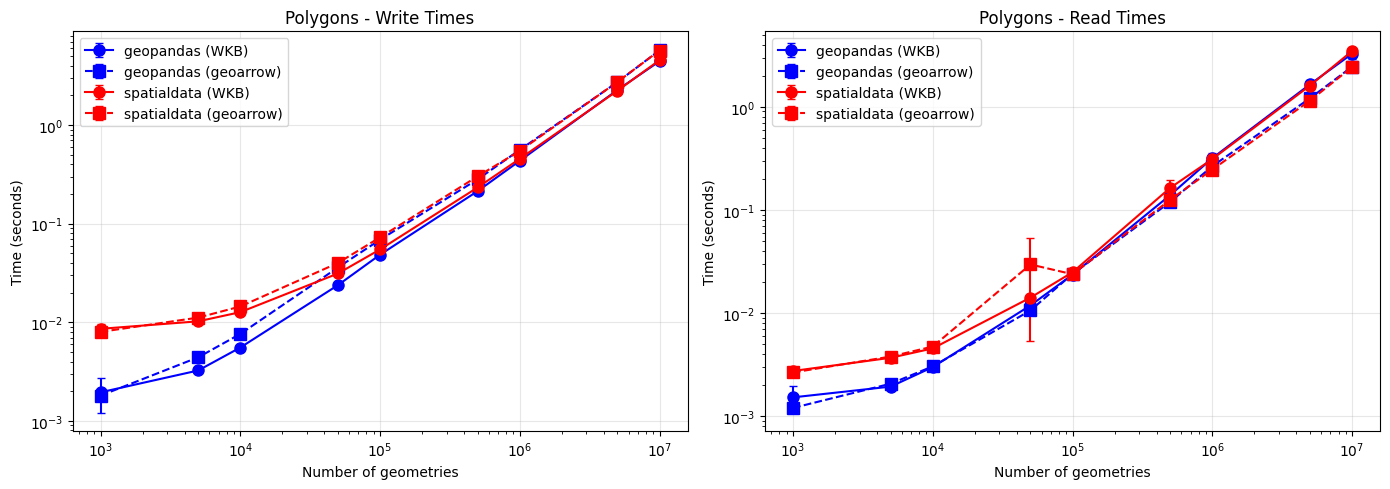

In [11]:
# Plot polygon results
fig_polygons = plot_benchmark_results(results_polygons, "Polygons")
plt.show()

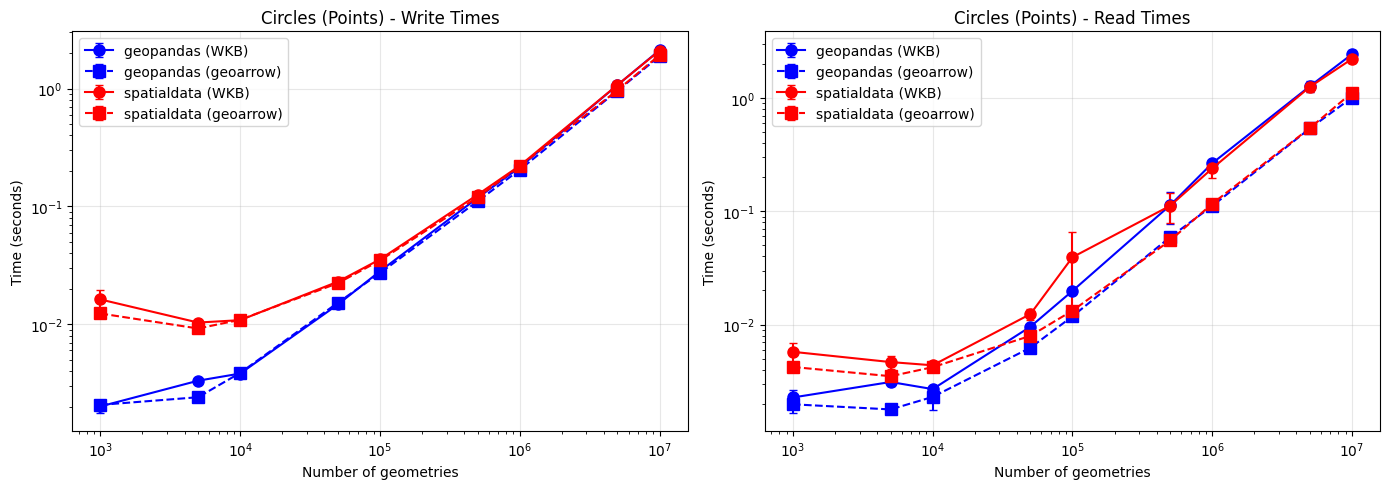

In [12]:
# Plot circle results
fig_circles = plot_benchmark_results(results_circles, "Circles (Points)")
plt.show()

## Comparison: Speedup of GeoArrow vs WKB

In [13]:
def compute_speedup(results: pd.DataFrame) -> pd.DataFrame:
    """Compute speedup of geoarrow over WKB."""
    speedups = []
    
    for size in SIZES:
        for method in METHODS:
            wkb_mask = (results['size'] == size) & (results['method'] == method) & (results['encoding'] == 'WKB')
            geoarrow_mask = (results['size'] == size) & (results['method'] == method) & (results['encoding'] == 'geoarrow')
            
            wkb_write = results[wkb_mask]['write_mean'].values[0]
            geoarrow_write = results[geoarrow_mask]['write_mean'].values[0]
            
            wkb_read = results[wkb_mask]['read_mean'].values[0]
            geoarrow_read = results[geoarrow_mask]['read_mean'].values[0]
            
            speedups.append({
                'size': size,
                'method': method,
                'write_speedup': wkb_write / geoarrow_write,  # >1 means geoarrow is faster
                'read_speedup': wkb_read / geoarrow_read,
            })
    
    return pd.DataFrame(speedups)

In [14]:
print("Speedup of GeoArrow over WKB (>1 means geoarrow is faster):")
print("\nPolygons:")
display(compute_speedup(results_polygons).pivot_table(
    index='size',
    columns='method',
    values=['write_speedup', 'read_speedup']
).round(2))

Speedup of GeoArrow over WKB (>1 means geoarrow is faster):

Polygons:


read_speedup             write_speedup            
method      geopandas spatialdata     geopandas spatialdata
size                                                       
1000             1.27        1.03          1.08        1.07
5000             0.94        0.97          0.74        0.92
10000            0.98        0.96          0.73        0.88
50000            1.12        0.48          0.66        0.78
100000           0.98        1.04          0.70        0.75
500000           1.16        1.31          0.76        0.77
1000000          1.19        1.26          0.78        0.83
5000000          1.36        1.40          0.83        0.81
10000000         1.33        1.43          0.78        0.80

In [15]:
print("\nCircles:")
display(compute_speedup(results_circles).pivot_table(
    index='size',
    columns='method',
    values=['write_speedup', 'read_speedup']
).round(2))


Circles:


read_speedup             write_speedup            
method      geopandas spatialdata     geopandas spatialdata
size                                                       
1000             1.15        1.36          0.97        1.32
5000             1.75        1.33          1.38        1.12
10000            1.17        1.04          0.99        0.99
50000            1.53        1.56          0.97        1.03
100000           1.68        2.96          1.04        1.02
500000           1.91        2.03          1.07        1.05
1000000          2.39        2.05          1.05        1.01
5000000          2.36        2.31          1.12        1.11
10000000         2.41        1.99          1.13        1.09

## Summary

This benchmark compares:
1. **WKB** (Well-Known Binary) - traditional geometry encoding
2. **GeoArrow** - columnar geometry encoding for better Arrow/Parquet integration

And two methods:
1. **geopandas** - direct `GeoDataFrame.to_parquet()` and `read_parquet()`
2. **spatialdata** - using `SpatialData.init_from_elements()`, `.write()` and `read_zarr()`

Key observations:
- GeoArrow encoding is generally faster for larger datasets
- spatialdata has some overhead due to zarr metadata and structure
- The performance difference becomes more pronounced with larger datasets